# SVM classification using active learning
Diane Lingrand (diane.lingrand@univ-cotedazur)

**DSAI evaluation, March 2022**

Write your name here:

Documentation SVM: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [1]:
#necessary imports
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score

## dataset: digits

In [2]:
# loading the dataset
from sklearn import datasets
(X,y) = datasets.load_digits(return_X_y=True)


**Question 1** 
- What is the dimension of the data space ? 
- How many data in the digits dataset ?

Compute these values (even if they are available on the net). Print the results in the form (10 and 100 are examples, not the correct values):

    Data are of dimension: 10.
    There are 100 data in the digits dataset.

In [3]:
print(f"Dimension of data: {X.shape[1]} (number of features)")
print(f"Number of samples: {len(X)}")

Dimension of data: 64 (number of features)
Number of samples: 1797


In [4]:
# you will consider only 2 classes: the 3's and the 7's
c1 = 3
c2 = 7

**Question 2:**

Set X to contain the part of the data from the original variable X that contains only data with labels 3 or 7. Set y to the corresponding labels: 0 value for class '3' and 1 value for class '7'.

In [5]:
df_full = pd.DataFrame(X)
df_full["target"] = y
df = df_full.copy()
df = df[(df["target"] == c1) | (df["target"] == c2)].reset_index(drop=True)
df["target"] = (df["target"] == 7).astype(int).values
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,0
1,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,...,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0,1
2,0.0,2.0,9.0,15.0,14.0,9.0,3.0,0.0,0.0,4.0,...,0.0,0.0,2.0,12.0,12.0,13.0,11.0,0.0,0.0,0
3,0.0,0.0,1.0,8.0,15.0,10.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,11.0,9.0,0.0,0.0,0.0,1
4,0.0,1.0,8.0,12.0,15.0,14.0,4.0,0.0,0.0,3.0,...,0.0,0.0,0.0,14.0,15.0,11.0,2.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,0.0,1.0,7.0,13.0,16.0,13.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,8.0,15.0,10.0,6.0,0.0,0.0,0
358,0.0,2.0,10.0,12.0,16.0,8.0,0.0,0.0,0.0,4.0,...,0.0,0.0,2.0,14.0,16.0,12.0,9.0,0.0,0.0,0
359,0.0,0.0,6.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,11.0,0.0,0.0,0.0,0.0,1
360,0.0,0.0,3.0,10.0,16.0,16.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,12.0,0.0,0.0,0.0,0.0,1


**Question 3:**

How many samples for class '3' and for class '7'? Print the values this way:
    
    There are ... data in class 3 and ... data in class 7.

In [6]:
print(f"""Number of samples for the class 3: {len(df[df["target"] == 0])}""")
print(f"""Number of samples for the class 7: {len(df[df["target"] == 1])}""")

Number of samples for the class 3: 183
Number of samples for the class 7: 179


In [7]:
X = df[[col for col in df.columns if col != "target"]]
y = df["target"]

In [8]:
# split into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


## Baseline: train a linear SVM on the whole train dataset

**Question 4:**

Using a linear kernel and a default C value to 1, learn the SVM classification of 3's versus 7's with the whole train dataset.


In [9]:
C_val = 1
svc = svm.SVC(kernel="linear", C=C_val)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

**Question 5:**

Compute the different metrics (F1 score, accuracy and confusion matrix) on the test dataset.

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

print(f"accuracy_score: {round(accuracy_score(y_test, y_pred), 4)}")
print(f"f1_score: {round(f1_score(y_test, y_pred), 4)}")

accuracy_score: 0.9931
f1_score: 0.9934


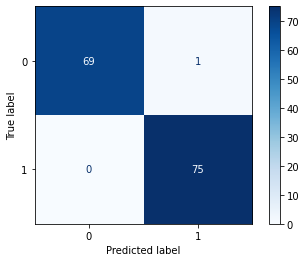

In [11]:
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
cm

## Active learning with SVM

Start with few annoted data and iterate by asking new labelled data and re-learn SVM separation. Try different selection of new labelled data.

In [12]:
# short reminder for random integers:
import random
a = random.randint(2, 15)
# a is random integer such that 2 <= a <= 15

In [13]:
# In order to avoid any modification in (xTrain, yTrain), we will work on a copy in the next cells:
random_state = 42
X_train_initial = X_train.copy().sample(n=len(X_train), random_state=random_state)
y_train_initial = y_train.copy().sample(n=len(X_train), random_state=random_state)
data_initial = pd.concat([X_train_initial, y_train_initial], axis=1)
data_initial

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
32,0.0,0.0,7.0,16.0,16.0,16.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,16.0,3.0,0.0,0.0,0.0,1
3,0.0,0.0,1.0,8.0,15.0,10.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,11.0,9.0,0.0,0.0,0.0,1
335,0.0,7.0,12.0,14.0,16.0,8.0,0.0,0.0,0.0,8.0,...,0.0,0.0,9.0,12.0,0.0,0.0,0.0,0.0,0.0,1
301,0.0,1.0,9.0,15.0,13.0,4.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,8.0,15.0,16.0,9.0,1.0,0.0,0
298,0.0,1.0,11.0,16.0,16.0,4.0,0.0,0.0,0.0,7.0,...,0.0,0.0,1.0,13.0,16.0,16.0,10.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.0,2.0,10.0,12.0,16.0,8.0,0.0,0.0,0.0,4.0,...,0.0,0.0,2.0,14.0,16.0,12.0,9.0,0.0,0.0,0
341,0.0,0.0,5.0,14.0,16.0,16.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,13.0,0.0,0.0,0.0,0.0,1
267,0.0,0.0,9.0,16.0,16.0,12.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,8.0,16.0,16.0,16.0,6.0,0.0,0
85,0.0,0.0,6.0,12.0,12.0,15.0,16.0,6.0,0.0,2.0,...,0.0,0.0,0.0,8.0,16.0,3.0,0.0,0.0,0.0,1


**Question 6: Initialisation of the active training dataset**

Construct a new training dataset named (xActif,yActif). For it's initialisation, take randomly nb0 data from the copy of the original training dataset (xTrainP, yTrainP). You are allowed to use informations from yTrainP in order to get half of nb0 data for each class. These nb0 data are also removed from (xTrainP,yTrainP). Removing data can be done using [np.delete](https://numpy.org/doc/stable/reference/generated/numpy.delete.html).

**Question 7: Iterations of the active learning** 

1. Learn a linear SVM classifier on the active training dataset
2. Compute the accuracy on the test dataset (not modified)
3. add randomly nb new data to the active training dataset and remove them from (xTrainP, yTrainP)
4. Go back to step 1 (20 times)

In [21]:
N_STARTING_PTS = 4  # number of data in the active training dataset at initialisation
N_NEW_POINTS = 2
THRESH = 0.001  # tolerance for stopping criterion
MAX_ITER_STAGNATION = 100
C_VAL = 1

store_accuracy = []
store_f1 = []
iter_stagnation = 0

curr_n_pts = N_STARTING_PTS
while curr_n_pts < len(X_train):
    X_active = X_train_initial.copy().iloc[:curr_n_pts]
    y_active = y_train_initial.copy().iloc[:curr_n_pts]
    # fit SVC
    svc = svm.SVC(kernel="linear", C=C_VAL)

    svc.fit(X_active, y_active)
    y_pred = svc.predict(X_test)

    # compute metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if len(store_f1) > 0:
        improvement_f1 = np.abs(store_f1[-1] - f1)
        if improvement_f1 < THRESH:
            iter_stagnation += 1
            if iter_stagnation >= MAX_ITER_STAGNATION:
                break

    store_accuracy.append(acc)
    store_f1.append(f1)

    curr_n_pts += N_NEW_POINTS


**Question 8: plot the evolution of the accuracy**

Plot the accuracy with respect to the iterations from the previous question.

In [15]:
# px.line()
df_res = pd.DataFrame({"acc": store_accuracy, "f1": store_f1})
px.line(df_res)

In [16]:
#write your solution here

**Question 9: strategy for choosing new data**
    
Same question as question 7 but, instead of choosing the new points randomly, at each iteration, choose the nb points that are the closest to the separation. The [decision_function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) from scikit-learn will help you.

In [17]:
#write your solution here

**Question 10: plot the evolution of the accuracy**

Plot the accuracy with respect to the iterations from the previous question.
Compare with question 8. Also compare with the baseline.

In [18]:
#write your solution here

**Question 11: many random starts**
    
Since the initialisation is random, running previous codes can lead to different curves for questions 8 and 10. Write here the code necessary for plotting several (e.g. 10) curves corresponding to questions 8 and 10 and display these new plots. Which one is the best strategy.
    

In [19]:
#write your solution here

**Question 12: hyperparameters**
So far, you have used the linear kernel with default parameter. Using the strategy of question 9, how could you choose the kernel and the hyperparameters ? Try different experiments such as:
- choose the kernel and hyperparams using nb0 at starting
- update kernel and hyperparams after few itertions
- compare different trials    
    

In [20]:
#write your solution here